In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "AP2"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn015881,MAYMNNWLGFSLSPQEHQNPQDHSQNSVSRLGFNTDKISGTDVSSD...,650,1
1,Achn066211,MLDLNLTAMPTDSISDGQMDDSGASNSSLLNVETSSVAVDEESSST...,405,1
2,Achn082221,MLDLNLSFARDEEYVSITEKFPEGSGGGAMDESGTSNSSIVNAEDD...,375,1
3,Achn088601,MEMITLVKSEVSPVRRRLCEMERDQKQPQQLLVDKSSATNTTVKRS...,312,1
4,Achn108581,MLDLNLSVVHNEDDSMEITNKFPEGSEGQMADSGTSTSSVVNAEGS...,426,1


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8894 entries, 0 to 8893
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8894 non-null   object
 1   sequence  8894 non-null   object
 2   length    8894 non-null   int64 
 3   class     8894 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 278.1+ KB


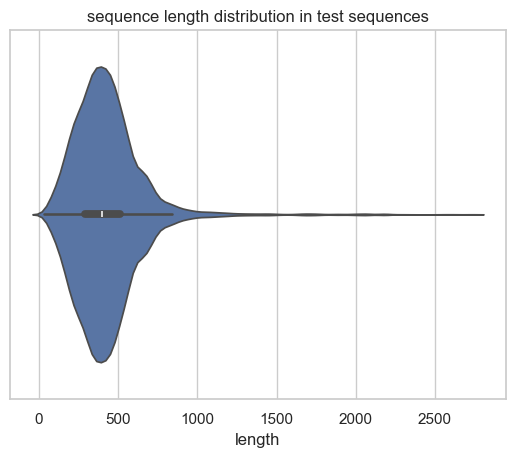

In [9]:
sns.set(style="whitegrid")
sns.violinplot(x=dataset.length)
plt.title("sequence length distribution in test sequences")
plt.show()

In [10]:
#report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [11]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [12]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
340,0.029091,0.000000,0.001818,0.005455,0.001818,0.025455,0.007273,0.005455,0.000000,0.014545,...,0.001818,0.001818,0.001818,0.001818,0.001818,0.0,0.000000,0.001818,0.0,0.010909
7839,0.013333,0.000000,0.002667,0.000000,0.000000,0.002667,0.000000,0.002667,0.002667,0.000000,...,0.002667,0.005333,0.000000,0.000000,0.005333,0.0,0.000000,0.000000,0.0,0.002667
2246,0.014109,0.000000,0.001764,0.001764,0.000000,0.005291,0.003527,0.003527,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.005291,0.000000,0.0,0.001764,0.000000,0.0,0.000000
2811,0.053208,0.003130,0.003130,0.004695,0.000000,0.006260,0.009390,0.004695,0.003130,0.003130,...,0.001565,0.000000,0.003130,0.004695,0.003130,0.0,0.003130,0.001565,0.0,0.006260
777,0.013544,0.002257,0.002257,0.006772,0.000000,0.006772,0.002257,0.006772,0.002257,0.000000,...,0.002257,0.004515,0.000000,0.004515,0.002257,0.0,0.000000,0.000000,0.0,0.000000


In [13]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 441)
X_test: (1779, 441)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [14]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 47s 534ms/step - accuracy: 0.4219 - loss: 0.6932

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7388 - loss: 0.6809   

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.6224

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8366 - loss: 0.5546 - val_accuracy: 0.9550 - val_loss: 0.1038


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0540

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9672 - loss: 0.0898

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9653 - loss: 0.0973

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9642 - loss: 0.1009

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9638 - loss: 0.1014 - val_accuracy: 0.9670 - val_loss: 0.0853


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0677

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.0852

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9678 - loss: 0.0833

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9692 - loss: 0.0814

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9693 - loss: 0.0816 - val_accuracy: 0.9705 - val_loss: 0.0858


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0183

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9689 - loss: 0.0684 

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9712 - loss: 0.0672

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9731 - loss: 0.0663

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9738 - loss: 0.0665 - val_accuracy: 0.9726 - val_loss: 0.0837


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0239

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0465 

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9831 - loss: 0.0484

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0502

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0513 - val_accuracy: 0.9705 - val_loss: 0.0802


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0300

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9773 - loss: 0.0605

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0629

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.0634 - val_accuracy: 0.9684 - val_loss: 0.0954


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0669

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0405

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0459

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0507

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0519 - val_accuracy: 0.9691 - val_loss: 0.0778


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0332

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0348

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0415

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.0460

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.0465 - val_accuracy: 0.9712 - val_loss: 0.0746


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.0927

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0523

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0477

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9824 - loss: 0.0447

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0444 - val_accuracy: 0.9712 - val_loss: 0.0999


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.1347

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0476

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0374

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0367

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0367 - val_accuracy: 0.9726 - val_loss: 0.0757


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0036

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0193

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0200

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0212

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0215 - val_accuracy: 0.9740 - val_loss: 0.0790


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0158

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0265

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0296

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0294

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0294 - val_accuracy: 0.9712 - val_loss: 0.0810


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0051

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0166

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0175

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0172

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0172 - val_accuracy: 0.9754 - val_loss: 0.0879


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0048

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0276

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0264

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0246

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0242 - val_accuracy: 0.9733 - val_loss: 0.0894


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0017

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0075

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0072

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0080

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0081 - val_accuracy: 0.9726 - val_loss: 0.1002


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0382

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0155

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0141

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0136

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0135 - val_accuracy: 0.9747 - val_loss: 0.0982


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0020

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0085

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0083

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0085

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 0.9733 - val_loss: 0.0937


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 9.1939e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0134    

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0163

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0174

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0175 - val_accuracy: 0.9684 - val_loss: 0.1297


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0422

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0132

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0138

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0140

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0140 - val_accuracy: 0.9705 - val_loss: 0.1125


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0012

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0055

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0061

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0077

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0079 - val_accuracy: 0.9733 - val_loss: 0.1147


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0180

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0130

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0126

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0117

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0116 - val_accuracy: 0.9754 - val_loss: 0.1090


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0012

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0052

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0087

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0103

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0104 - val_accuracy: 0.9733 - val_loss: 0.1031


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0207

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0058

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0042

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0036 - val_accuracy: 0.9733 - val_loss: 0.1143



[Train Accuracy: 99.95% - Test Accuracy: 96.91%]


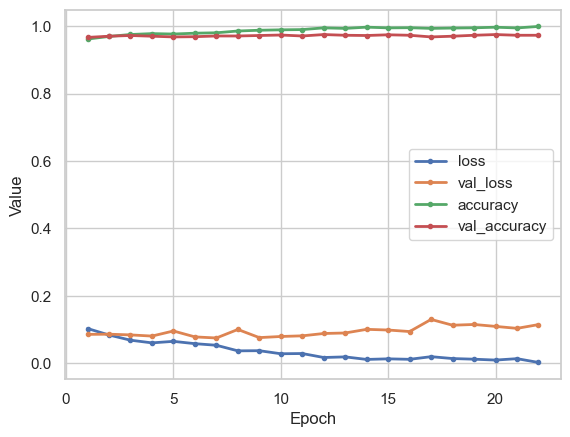

In [15]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [16]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [17]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
8289,0.002208,0.0,0.002208,0.002208,0.000000,0.002208,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7638,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001218,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8799,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.004587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8759,0.000000,0.0,0.000000,0.000000,0.002941,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 8898)
X_test: (1779, 8898)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [19]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,278,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,321,409 (8.86 MB)

 Trainable params: 2,321,409 (8.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 49s 567ms/step - accuracy: 0.5625 - loss: 0.6931

 7/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5462 - loss: 0.6923   

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5437 - loss: 0.6899

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5724 - loss: 0.6851

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6044 - loss: 0.6779

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6328 - loss: 0.6672

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6574 - loss: 0.6528

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6757 - loss: 0.6380

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6918 - loss: 0.6220

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7059 - loss: 0.6057

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7187 - loss: 0.5893

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7301 - loss: 0.5731

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7406 - loss: 0.5574

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7501 - loss: 0.5424

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7560 - loss: 0.5329 - val_accuracy: 0.9845 - val_loss: 0.0525


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9688 - loss: 0.0538

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9767 - loss: 0.0577 

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9782 - loss: 0.0560

20/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9785 - loss: 0.0562

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9789 - loss: 0.0559

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9795 - loss: 0.0550

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9803 - loss: 0.0537

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9809 - loss: 0.0524

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9814 - loss: 0.0513

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9818 - loss: 0.0504

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9822 - loss: 0.0496

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9826 - loss: 0.0489

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9829 - loss: 0.0484

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9832 - loss: 0.0480

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9834 - loss: 0.0476 - val_accuracy: 0.9726 - val_loss: 0.0795


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9844 - loss: 0.0410

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9868 - loss: 0.0299 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9887 - loss: 0.0265

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9903 - loss: 0.0236

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9914 - loss: 0.0216

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9921 - loss: 0.0202

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9926 - loss: 0.0195

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9929 - loss: 0.0191

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9931 - loss: 0.0187

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9933 - loss: 0.0184

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9935 - loss: 0.0181

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9936 - loss: 0.0180

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9937 - loss: 0.0179 - val_accuracy: 0.9831 - val_loss: 0.0547


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 9.7502e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0064     

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0061

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0057

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0054

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0051

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0050

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0048

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0048

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0047

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0047

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0046

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 0.0046 - val_accuracy: 0.9838 - val_loss: 0.0563


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 5.1878e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0087     

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0098

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0091

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0083

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0076

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0073

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0070

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0067

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0064

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0062

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0059

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9989 - loss: 0.0059 - val_accuracy: 0.9810 - val_loss: 0.0615


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 5.5315e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6177e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9586e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1921e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6592e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2046e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9622e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8611e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9301e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0235e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0899e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1186e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.1301e-04 - val_accuracy: 0.9817 - val_loss: 0.0697


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.1449e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0065e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0212e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8229e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6196e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4347e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2526e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0956e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9736e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8732e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7935e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7252e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.7004e-04 - val_accuracy: 0.9817 - val_loss: 0.0645


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.4919e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4630e-04 

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3037e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4486e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5121e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5556e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5594e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5226e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4662e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4124e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3542e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3125e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.3076e-04 - val_accuracy: 0.9817 - val_loss: 0.0693


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.1816e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5049e-04 

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5230e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5388e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5914e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6294e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6524e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6601e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6580e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6593e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6669e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6707e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6734e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.7219e-04 - val_accuracy: 0.9782 - val_loss: 0.0974


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 0.0037

 7/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0015 

14/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 9.6780e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.6334e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.5729e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 5.8402e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1527e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8009e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6842e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5983e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5109e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4138e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3129e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.2885e-04 - val_accuracy: 0.9838 - val_loss: 0.0838


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 9.6561e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8373e-05 

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8477e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9730e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9464e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2476e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 4.8518e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 6.6975e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 8.0042e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 8.9537e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 9.5800e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0010    

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9817 - val_loss: 0.0724



[Train Accuracy: 99.96% - Test Accuracy: 97.98%]


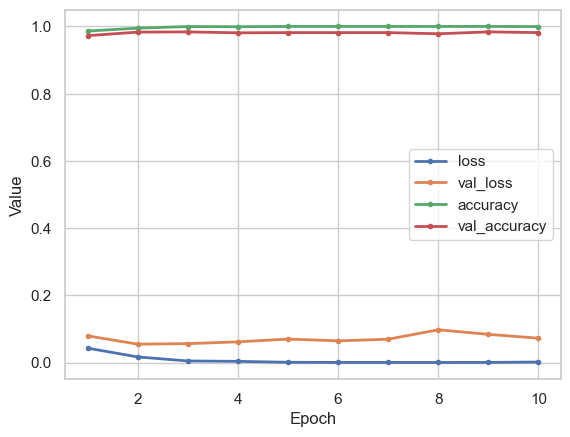

In [20]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [21]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [22]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
8289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [24]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,890,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,931,457 (148.51 MB)

 Trainable params: 38,931,457 (148.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1:07 765ms/step - accuracy: 0.4688 - loss: 0.6932

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4805 - loss: 0.6932 

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4939 - loss: 0.6931

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5042 - loss: 0.6931

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5153 - loss: 0.6931

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5244 - loss: 0.6930

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5308 - loss: 0.6929

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5375 - loss: 0.6928

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5460 - loss: 0.6927 

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5533 - loss: 0.6926

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.5603 - loss: 0.6925

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5668 - loss: 0.6924

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5734 - loss: 0.6922

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5801 - loss: 0.6920

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5871 - loss: 0.6918

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5940 - loss: 0.6916

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6011 - loss: 0.6914

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6079 - loss: 0.6912

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6147 - loss: 0.6909

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6213 - loss: 0.6906

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6279 - loss: 0.6903

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6342 - loss: 0.6899

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.6404 - loss: 0.6895

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.6465 - loss: 0.6891

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6523 - loss: 0.6886

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.6579 - loss: 0.6881

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.6633 - loss: 0.6876

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6685 - loss: 0.6870

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.6735 - loss: 0.6864

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6783 - loss: 0.6858

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.6830 - loss: 0.6851

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.6874 - loss: 0.6844

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.6917 - loss: 0.6836

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.6958 - loss: 0.6828

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.6998 - loss: 0.6819

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7036 - loss: 0.6810

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7074 - loss: 0.6800

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7110 - loss: 0.6789

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7146 - loss: 0.6777

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7180 - loss: 0.6766

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7214 - loss: 0.6753

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7246 - loss: 0.6740

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7277 - loss: 0.6726

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7308 - loss: 0.6711

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7338 - loss: 0.6696

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7367 - loss: 0.6680

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7395 - loss: 0.6663

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7422 - loss: 0.6646

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7449 - loss: 0.6628

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7475 - loss: 0.6609

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7500 - loss: 0.6591

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7524 - loss: 0.6572

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7547 - loss: 0.6552

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7570 - loss: 0.6532

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7592 - loss: 0.6512

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7614 - loss: 0.6491

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7635 - loss: 0.6470

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7656 - loss: 0.6448

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7676 - loss: 0.6426

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7696 - loss: 0.6404

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7716 - loss: 0.6381

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7735 - loss: 0.6358

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7753 - loss: 0.6335

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7772 - loss: 0.6311

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7790 - loss: 0.6287

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7807 - loss: 0.6263

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7825 - loss: 0.6239

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7842 - loss: 0.6215

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7858 - loss: 0.6190

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7875 - loss: 0.6166

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7891 - loss: 0.6142

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7906 - loss: 0.6117

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7922 - loss: 0.6093

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7937 - loss: 0.6069

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7951 - loss: 0.6045

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7966 - loss: 0.6021

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7980 - loss: 0.5997

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7994 - loss: 0.5973

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8007 - loss: 0.5949

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8021 - loss: 0.5925

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8034 - loss: 0.5901

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8047 - loss: 0.5878

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8060 - loss: 0.5854

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8072 - loss: 0.5831

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8085 - loss: 0.5808

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8097 - loss: 0.5785

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8109 - loss: 0.5762

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8120 - loss: 0.5739

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8132 - loss: 0.5716

89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.8143 - loss: 0.5694 - val_accuracy: 0.9761 - val_loss: 0.0708


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 31s 362ms/step - accuracy: 0.9844 - loss: 0.0489

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.9805 - loss: 0.0511

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9800 - loss: 0.0504

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9811 - loss: 0.0497

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9824 - loss: 0.0480

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9836 - loss: 0.0462

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.9843 - loss: 0.0455

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9848 - loss: 0.0448

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9852 - loss: 0.0442

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9851 - loss: 0.0440

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9852 - loss: 0.0436

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9852 - loss: 0.0432

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9851 - loss: 0.0430

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9851 - loss: 0.0429

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9851 - loss: 0.0426

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9852 - loss: 0.0423

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9852 - loss: 0.0420 

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9852 - loss: 0.0418

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9852 - loss: 0.0415

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9852 - loss: 0.0413

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9853 - loss: 0.0410

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9854 - loss: 0.0407

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9855 - loss: 0.0404

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9856 - loss: 0.0400

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9857 - loss: 0.0398

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9858 - loss: 0.0395

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9859 - loss: 0.0392

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9861 - loss: 0.0389

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9862 - loss: 0.0385

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9863 - loss: 0.0382

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9864 - loss: 0.0379

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9866 - loss: 0.0376

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9867 - loss: 0.0373

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9868 - loss: 0.0371

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9869 - loss: 0.0369

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9870 - loss: 0.0366

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9871 - loss: 0.0365

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9871 - loss: 0.0363

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9872 - loss: 0.0361

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9873 - loss: 0.0359

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9874 - loss: 0.0358

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9874 - loss: 0.0357

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9875 - loss: 0.0356

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9876 - loss: 0.0355

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9876 - loss: 0.0354

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9877 - loss: 0.0353

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9877 - loss: 0.0352

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9878 - loss: 0.0351

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9878 - loss: 0.0350

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9878 - loss: 0.0349

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9879 - loss: 0.0348

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9879 - loss: 0.0347

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9880 - loss: 0.0346

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9880 - loss: 0.0345

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9881 - loss: 0.0344

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9881 - loss: 0.0343

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9881 - loss: 0.0342

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9882 - loss: 0.0341

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9882 - loss: 0.0340

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9883 - loss: 0.0339

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9883 - loss: 0.0338

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9883 - loss: 0.0337

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9884 - loss: 0.0336

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9884 - loss: 0.0335

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9885 - loss: 0.0333

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9885 - loss: 0.0332

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9886 - loss: 0.0331

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9886 - loss: 0.0330

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9886 - loss: 0.0329

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9887 - loss: 0.0328

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9887 - loss: 0.0327

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9887 - loss: 0.0326

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9888 - loss: 0.0325

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9888 - loss: 0.0324

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9889 - loss: 0.0323

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9889 - loss: 0.0323

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9889 - loss: 0.0322

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9890 - loss: 0.0321

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9890 - loss: 0.0320

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9890 - loss: 0.0319

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9891 - loss: 0.0318

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9891 - loss: 0.0317

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9891 - loss: 0.0316

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9892 - loss: 0.0315

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9892 - loss: 0.0314

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9892 - loss: 0.0313

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9893 - loss: 0.0312

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9893 - loss: 0.0311

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9893 - loss: 0.0311

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.9894 - loss: 0.0310 - val_accuracy: 0.9768 - val_loss: 0.0617


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 1.0000 - loss: 0.0028

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 0.0028

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 0.0030

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 0.0031

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 0.0034

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 0.0036

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 0.0038

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 0.0039

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 0.0040

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 0.0040

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 0.0040

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 0.0041

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 0.0041

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 0.0041

15/89 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9999 - loss: 0.0042

16/89 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9999 - loss: 0.0042

17/89 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9998 - loss: 0.0042

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9998 - loss: 0.0042

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9998 - loss: 0.0042

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9997 - loss: 0.0042

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9997 - loss: 0.0043

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9997 - loss: 0.0043 

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9997 - loss: 0.0042

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9997 - loss: 0.0042

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9996 - loss: 0.0042

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9996 - loss: 0.0042

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9996 - loss: 0.0042

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9996 - loss: 0.0042

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9996 - loss: 0.0042

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9996 - loss: 0.0042

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9996 - loss: 0.0042

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9996 - loss: 0.0042

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9996 - loss: 0.0042

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9996 - loss: 0.0042

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9996 - loss: 0.0042

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9996 - loss: 0.0042

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9996 - loss: 0.0042

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9996 - loss: 0.0042

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9996 - loss: 0.0041

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9996 - loss: 0.0041

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9996 - loss: 0.0041

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9996 - loss: 0.0041

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9996 - loss: 0.0041

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9996 - loss: 0.0041

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9996 - loss: 0.0041

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9996 - loss: 0.0041

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9996 - loss: 0.0041

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9996 - loss: 0.0041

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9996 - loss: 0.0041

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9996 - loss: 0.0041

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9996 - loss: 0.0041

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9996 - loss: 0.0041

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9996 - loss: 0.0041

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9996 - loss: 0.0041

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9996 - loss: 0.0041

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9996 - loss: 0.0041

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9996 - loss: 0.0042

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9995 - loss: 0.0042

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9995 - loss: 0.0042

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9995 - loss: 0.0042

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9995 - loss: 0.0043

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9995 - loss: 0.0043

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9995 - loss: 0.0043

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9995 - loss: 0.0043

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9995 - loss: 0.0043

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9995 - loss: 0.0043

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9995 - loss: 0.0043

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9995 - loss: 0.0043

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9995 - loss: 0.0043

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9995 - loss: 0.0044

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9995 - loss: 0.0044

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9995 - loss: 0.0044

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9995 - loss: 0.0044

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9995 - loss: 0.0044

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9995 - loss: 0.0044

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9995 - loss: 0.0044

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9995 - loss: 0.0044

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9995 - loss: 0.0044

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9995 - loss: 0.0044

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9995 - loss: 0.0044

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9995 - loss: 0.0044

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9995 - loss: 0.0044

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9995 - loss: 0.0044

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9995 - loss: 0.0044

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9995 - loss: 0.0044

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9995 - loss: 0.0044

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9995 - loss: 0.0044

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9995 - loss: 0.0044

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9995 - loss: 0.0044

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9761 - val_loss: 0.0713


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 1.0000 - loss: 0.0011

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 0.0012

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 0.0012

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 0.0013

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 0.0013

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 0.0013

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 0.0013

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 0.0013

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 0.0013

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 0.0013

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 0.0013

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 0.0013

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 0.0013

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 0.0013

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 0.0013 

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 0.0012

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 0.0012

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 0.0012

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 0.0012

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 0.0012

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 0.0012

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 0.0012

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 0.0012

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 0.0012

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 0.0012

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 0.0013

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 0.0012

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 0.0013

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 0.0013

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 0.0014

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 0.0014

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9999 - loss: 0.0015

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9999 - loss: 0.0015

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9999 - loss: 0.0016

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9999 - loss: 0.0016

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0016

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0017

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0017

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0017

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0018

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0018

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0018

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9999 - loss: 0.0018

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9998 - loss: 0.0018

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9998 - loss: 0.0018

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9998 - loss: 0.0019

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9998 - loss: 0.0019

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9998 - loss: 0.0019

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9998 - loss: 0.0019

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9998 - loss: 0.0019

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9998 - loss: 0.0019

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9998 - loss: 0.0019

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9998 - loss: 0.0019

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9998 - loss: 0.0019

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9998 - loss: 0.0019

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9998 - loss: 0.0020

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9998 - loss: 0.0020

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9998 - loss: 0.0020

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9998 - loss: 0.0020

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9998 - loss: 0.0020

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9998 - loss: 0.0020

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9998 - loss: 0.0020

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9998 - loss: 0.0020

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9998 - loss: 0.0020

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9998 - loss: 0.0020

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9998 - loss: 0.0020

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9998 - loss: 0.0020

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9998 - loss: 0.0020

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9998 - loss: 0.0020

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9998 - loss: 0.0020

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9998 - loss: 0.0020

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9998 - loss: 0.0020

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9998 - loss: 0.0020

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9998 - loss: 0.0020

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9998 - loss: 0.0020

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9998 - loss: 0.0020

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9998 - loss: 0.0020

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9998 - loss: 0.0020

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9998 - loss: 0.0020

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9998 - loss: 0.0020

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9998 - loss: 0.0020

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9998 - loss: 0.0020

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9998 - loss: 0.0020

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9998 - loss: 0.0020

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9998 - loss: 0.0020

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9998 - loss: 0.0020

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9998 - loss: 0.0020

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9998 - loss: 0.0020

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9747 - val_loss: 0.0775


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 1.0000 - loss: 2.5232e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 3.9630e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 4.0753e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 4.0232e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.9986e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 4.0110e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 4.0790e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 4.1177e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 4.1384e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.1397e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 4.1740e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 4.1893e-04 

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 4.2384e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 4.2776e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.3001e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 4.3193e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 4.3315e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.3361e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 4.3412e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 4.3434e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.3423e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 4.3433e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.3444e-04 

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 4.3447e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 4.3441e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.3402e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.3350e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.3336e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 4.3303e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 4.3322e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 4.3349e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 4.3434e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 4.3485e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 4.3512e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 4.3524e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 4.3533e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 4.3534e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 4.3559e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 4.3588e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 4.3605e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 4.3608e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 4.3646e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 4.3674e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 4.3692e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 4.3702e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 4.3711e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 4.3731e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 4.3741e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 4.3742e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 4.3744e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 4.3749e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 4.3751e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 4.3747e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 4.3733e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 4.3715e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 4.3710e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 4.3716e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 4.3720e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 4.3722e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 4.3719e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 4.3716e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 4.3710e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 4.3704e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 4.3697e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 4.3704e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 4.3707e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.3707e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.3704e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.3700e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 4.3691e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 4.3678e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.3662e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 4.3649e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 4.3633e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 4.3625e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 4.3614e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 4.3600e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.3587e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.3570e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.3551e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.3540e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.3527e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 4.3511e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 4.3491e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 4.3478e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 4.3462e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 4.3444e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 4.3428e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 4.3410e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 1.0000 - loss: 4.3393e-04 - val_accuracy: 0.9747 - val_loss: 0.0816


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 1.0000 - loss: 1.8828e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 2.2551e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 2.2971e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.2739e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 2.2815e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 2.2981e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.2858e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.3399e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.4073e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.4470e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.4671e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 2.4820e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.4862e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.4935e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.5001e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 2.5062e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.5137e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.5165e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.5543e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.5862e-04 

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.6175e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.6432e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.6649e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.6818e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.6950e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.7048e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.7116e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.7199e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.7426e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7622e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7803e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7980e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.8123e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.8266e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.8391e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.8502e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.8593e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.8702e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.8797e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.8889e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.8963e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.9021e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.9089e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.9143e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9187e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.9228e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.9260e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9293e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.9315e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.9332e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.9345e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.9353e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.9354e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.9347e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.9338e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 2.9324e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 2.9309e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 2.9291e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 2.9268e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 2.9244e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 2.9277e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 2.9306e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 2.9331e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 2.9353e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 2.9369e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 1.0000 - loss: 2.9386e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 1.0000 - loss: 2.9397e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 1.0000 - loss: 2.9430e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 1.0000 - loss: 2.9465e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 1.0000 - loss: 2.9494e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 2.9523e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 2.9546e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 2.9566e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 2.9585e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 2.9600e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 2.9612e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 2.9620e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 2.9624e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 2.9626e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 1.0000 - loss: 2.9630e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 1.0000 - loss: 2.9634e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 1.0000 - loss: 2.9634e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 2.9637e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 2.9637e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 2.9637e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 2.9635e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 2.9633e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 2.9628e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 2.9624e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 1.0000 - loss: 2.9620e-04 - val_accuracy: 0.9754 - val_loss: 0.0900


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step - accuracy: 1.0000 - loss: 1.5477e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 1.0000 - loss: 1.3713e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 1.0000 - loss: 1.3382e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 1.0000 - loss: 1.3302e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 1.0000 - loss: 1.4658e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - accuracy: 1.0000 - loss: 1.5666e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 1.0000 - loss: 1.6094e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 1.0000 - loss: 1.6386e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 1.0000 - loss: 1.6503e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 1.0000 - loss: 1.6505e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 1.0000 - loss: 1.6640e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 1.0000 - loss: 1.6683e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 1.0000 - loss: 1.7345e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 1.0000 - loss: 1.7840e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 1.0000 - loss: 1.8193e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 1.0000 - loss: 1.8475e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 1.0000 - loss: 1.8684e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 1.0000 - loss: 1.8826e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 1.0000 - loss: 1.8925e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 1.0000 - loss: 1.9009e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 1.0000 - loss: 1.9058e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 1.0000 - loss: 1.9070e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 1.0000 - loss: 1.9070e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 1.0000 - loss: 1.9079e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 1.0000 - loss: 1.9118e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 1.0000 - loss: 1.9139e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 1.0000 - loss: 1.9150e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 1.0000 - loss: 1.9160e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 1.0000 - loss: 1.9181e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 1.0000 - loss: 1.9189e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 1.0000 - loss: 1.9189e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 1.0000 - loss: 1.9195e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 1.0000 - loss: 1.9198e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 1.0000 - loss: 1.9196e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 1.0000 - loss: 1.9186e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 1.0000 - loss: 1.9171e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 1.0000 - loss: 1.9150e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 1.0000 - loss: 1.9126e-04 

39/89 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 1.0000 - loss: 1.9096e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 1.0000 - loss: 1.9061e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 1.0000 - loss: 1.9023e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 1.0000 - loss: 1.8989e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 1.0000 - loss: 1.8958e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 1.0000 - loss: 1.8934e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 1.0000 - loss: 1.8906e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 1.0000 - loss: 1.8875e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 1.0000 - loss: 1.8851e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 1.0000 - loss: 1.8831e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 1.0000 - loss: 1.8858e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 1.0000 - loss: 1.8878e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 1.0000 - loss: 1.8893e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 1.0000 - loss: 1.8905e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 1.0000 - loss: 1.8912e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 1.0000 - loss: 1.8920e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 1.0000 - loss: 1.8925e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 1.0000 - loss: 1.8930e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 1.0000 - loss: 1.8935e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 1.0000 - loss: 1.8935e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 1.0000 - loss: 1.8932e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 1.0000 - loss: 1.8929e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 1.0000 - loss: 1.8937e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 1.0000 - loss: 1.8942e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 1.0000 - loss: 1.8944e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 1.0000 - loss: 1.8944e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 1.0000 - loss: 1.8943e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 1.0000 - loss: 1.8942e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 1.0000 - loss: 1.8940e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 1.0000 - loss: 1.8936e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 1.0000 - loss: 1.8932e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 1.0000 - loss: 1.8925e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 1.0000 - loss: 1.8920e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 1.0000 - loss: 1.8913e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 1.0000 - loss: 1.8920e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 1.0000 - loss: 1.8925e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 1.0000 - loss: 1.8931e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 1.0000 - loss: 1.8937e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 1.0000 - loss: 1.8945e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 1.0000 - loss: 1.8950e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 1.0000 - loss: 1.8954e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 1.0000 - loss: 1.8956e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 1.0000 - loss: 1.8957e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 1.0000 - loss: 1.8956e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 1.0000 - loss: 1.8953e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 1.0000 - loss: 1.8950e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 1.0000 - loss: 1.8947e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 1.0000 - loss: 1.8942e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 1.0000 - loss: 1.8935e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 1.0000 - loss: 1.8926e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 1.0000 - loss: 1.8918e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 1.0000 - loss: 1.8910e-04 - val_accuracy: 0.9740 - val_loss: 0.0875


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 33s 381ms/step - accuracy: 1.0000 - loss: 4.9822e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 7.4573e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 8.0434e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 1.0000 - loss: 8.1158e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 1.0000 - loss: 8.3911e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 1.0000 - loss: 8.5331e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 1.0000 - loss: 8.6812e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 1.0000 - loss: 8.9052e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 1.0000 - loss: 9.3764e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 1.0000 - loss: 9.7359e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 1.0061e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 1.0317e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 1.0484e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 1.0634e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.0912e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.1131e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.1302e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.1439e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.1545e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.1640e-04 

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1715e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1768e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.1812e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1844e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1862e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1883e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.1922e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.1961e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.1995e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.2073e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.2143e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.2213e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.2316e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2406e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.2485e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.2563e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.2629e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.2686e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.2734e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.2777e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.2815e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.2846e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 1.2874e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 1.2895e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 1.2914e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 1.2928e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 1.3006e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 1.3080e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 1.3146e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 1.0000 - loss: 1.3205e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 1.0000 - loss: 1.3258e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 1.0000 - loss: 1.3310e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 1.0000 - loss: 1.3358e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 1.3410e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 1.3458e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 1.3502e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 1.0000 - loss: 1.3542e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 1.3579e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 1.3612e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 1.3643e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 1.0000 - loss: 1.3673e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 1.0000 - loss: 1.3699e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 1.0000 - loss: 1.3722e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 1.0000 - loss: 1.3742e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 1.0000 - loss: 1.3759e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 1.0000 - loss: 1.3799e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 1.3836e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 1.3870e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 1.3902e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 1.3931e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 1.0000 - loss: 1.3957e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 1.0000 - loss: 1.3981e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 1.4003e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 1.4023e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 1.4041e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 1.4057e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 1.0000 - loss: 1.4070e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 1.0000 - loss: 1.4082e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 1.0000 - loss: 1.4095e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 1.0000 - loss: 1.4106e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 1.0000 - loss: 1.4118e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 1.0000 - loss: 1.4129e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 1.0000 - loss: 1.4139e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 1.0000 - loss: 1.4148e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 1.0000 - loss: 1.4156e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 1.4162e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 1.4167e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 1.4171e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 1.4176e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 1.0000 - loss: 1.4180e-04 - val_accuracy: 0.9740 - val_loss: 0.0906


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 35s 409ms/step - accuracy: 1.0000 - loss: 1.1073e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.7035e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 1.0000 - loss: 1.7840e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 1.0000 - loss: 1.7520e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 1.0000 - loss: 1.7484e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 1.0000 - loss: 1.7246e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 1.0000 - loss: 1.6880e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 1.0000 - loss: 1.6490e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 1.0000 - loss: 1.6077e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 1.0000 - loss: 1.5707e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 1.0000 - loss: 1.5329e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 1.0000 - loss: 1.5009e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 1.0000 - loss: 1.4692e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 1.0000 - loss: 1.4393e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 1.0000 - loss: 1.4124e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 1.0000 - loss: 1.3883e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 1.0000 - loss: 1.3675e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 1.0000 - loss: 1.3472e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 1.0000 - loss: 1.3277e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 1.0000 - loss: 1.3088e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 1.0000 - loss: 1.2914e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 1.0000 - loss: 1.2753e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 1.0000 - loss: 1.2652e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 1.2548e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 1.0000 - loss: 1.2448e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 1.2350e-04 

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 1.0000 - loss: 1.2276e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 1.0000 - loss: 1.2219e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 1.0000 - loss: 1.2165e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 1.0000 - loss: 1.2110e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 1.2087e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 1.2060e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 1.2034e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 1.2003e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 1.1968e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 1.1931e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.1895e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.1866e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.1836e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.1804e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.1775e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.1746e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.1719e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.1691e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.1665e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.1639e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.1611e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.1584e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.1555e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.1533e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.1511e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.1488e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.1467e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.1447e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.1428e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.1407e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.1388e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.1368e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.1347e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.1325e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.1303e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.1280e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.1256e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.1232e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.1208e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.1186e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.1163e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.1139e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.1117e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.1094e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.1072e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.1049e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.1027e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.1006e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.0983e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.0961e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.0943e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.0925e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0909e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0892e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0877e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0861e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0847e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0833e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0819e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0805e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.0791e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.0776e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.0762e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 1.0000 - loss: 1.0747e-04 - val_accuracy: 0.9747 - val_loss: 0.0943


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 27s 318ms/step - accuracy: 1.0000 - loss: 1.5966e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.8225e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 4.3933e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 4.5102e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 4.8314e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 6.2001e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.0213e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.4758e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.7648e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.9945e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 8.2622e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 8.4699e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 8.6167e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 8.7471e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 8.8374e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 8.8938e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 8.9478e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 8.9731e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 8.9862e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 8.9956e-05 

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 9.0043e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 9.0841e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.1469e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.2046e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 9.2455e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.2828e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.3118e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.3347e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.3496e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.3569e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.3654e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.4359e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.4954e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.5470e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.5941e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.6380e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.6747e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 9.7077e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 9.7344e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 9.7800e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 9.8189e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.8539e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.8851e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.9121e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 9.9595e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.0001e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.0037e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.0069e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.0097e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.0120e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 1.0140e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 1.0157e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 1.0171e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.0182e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.0193e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.0200e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.0206e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.0210e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.0213e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.0214e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.0212e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.0210e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.0206e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.0221e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.0235e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.0246e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.0257e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.0265e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.0273e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.0279e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.0283e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.0287e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.0292e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.0296e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.0300e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.0302e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.0303e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.0303e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.0302e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.0300e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.0298e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.0295e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.0291e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.0286e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.0281e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.0275e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.0268e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.0260e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.0254e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.0248e-04 - val_accuracy: 0.9740 - val_loss: 0.0984


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 39s 446ms/step - accuracy: 1.0000 - loss: 3.9784e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 1.0000 - loss: 4.7640e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 1.0000 - loss: 4.7880e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 1.0000 - loss: 4.6509e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 1.0000 - loss: 4.8606e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 1.0000 - loss: 5.0193e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 1.0000 - loss: 5.1122e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 5.1630e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 1.0000 - loss: 5.1589e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 1.0000 - loss: 5.1758e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 1.0000 - loss: 5.2048e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 1.0000 - loss: 5.2144e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 1.0000 - loss: 5.2105e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 1.0000 - loss: 5.2045e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 1.0000 - loss: 5.1926e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 1.0000 - loss: 5.1789e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 1.0000 - loss: 5.1603e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 1.0000 - loss: 5.1523e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 1.0000 - loss: 5.1417e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 1.0000 - loss: 5.1351e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 1.0000 - loss: 5.1316e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 1.0000 - loss: 5.1290e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 1.0000 - loss: 5.1219e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 1.0000 - loss: 5.1106e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 1.0000 - loss: 5.0959e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 1.0000 - loss: 5.0814e-05 

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 1.0000 - loss: 5.0774e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 1.0000 - loss: 5.0714e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 5.0674e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 1.0000 - loss: 5.0615e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 1.0000 - loss: 5.0550e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 1.0000 - loss: 5.0490e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 1.0000 - loss: 5.0783e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 1.0000 - loss: 5.1058e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 1.0000 - loss: 5.1296e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 1.0000 - loss: 5.1521e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 1.0000 - loss: 5.1755e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 5.2083e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 5.2441e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 5.2747e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 5.3038e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 5.3303e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 5.3551e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 5.3836e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 5.4172e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 5.4477e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 5.4943e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 5.5382e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 1.0000 - loss: 5.5784e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 1.0000 - loss: 5.6152e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 1.0000 - loss: 5.6503e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 1.0000 - loss: 5.6824e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 1.0000 - loss: 5.7126e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 1.0000 - loss: 5.7410e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 5.7684e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 5.7947e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 5.8204e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 5.8444e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 5.8668e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 5.8897e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 5.9119e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 5.9332e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 5.9542e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 5.9738e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 1.0000 - loss: 5.9918e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 1.0000 - loss: 6.0080e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 1.0000 - loss: 6.0280e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 1.0000 - loss: 6.0472e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 1.0000 - loss: 6.0648e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 1.0000 - loss: 6.0811e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 6.0963e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 6.1108e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 6.1245e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 6.1382e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 6.1511e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 6.1632e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 6.1739e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 6.1848e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 6.1950e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 6.2048e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 6.2140e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 6.2229e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 6.2315e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 6.2391e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 6.2471e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 6.2545e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 6.2618e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 6.2685e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 6.2745e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 1.0000 - loss: 6.2804e-05 - val_accuracy: 0.9740 - val_loss: 0.0978


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 1.0000 - loss: 4.3778e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 4.0544e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.5943e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.8673e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 4.9243e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 5.3393e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 5.6839e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 5.9118e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 6.0384e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 6.0974e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 6.1051e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 6.0917e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 6.0618e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 6.0395e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 6.0113e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.9741e-05 

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.9493e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 5.9213e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 5.8921e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.8584e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 5.8225e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 5.7855e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 5.7477e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 5.7130e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 5.6778e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 5.6410e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 5.6051e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 5.5766e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 5.5473e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.5175e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.4885e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4644e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.4386e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.4136e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 5.3888e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 5.3637e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.3403e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 5.3184e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 5.2964e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 5.2765e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 5.2568e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 5.2396e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 5.2229e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.2066e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.1903e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 5.1737e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.1573e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.1481e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.1404e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.1318e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.1227e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.1147e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.1081e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 5.1028e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 5.0965e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 5.0896e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 5.0828e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 5.0760e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 5.0689e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 5.0625e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 5.0557e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 5.0484e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 5.0409e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 5.0333e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 5.0261e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 5.0195e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 5.0126e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.0061e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 4.9999e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 4.9938e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 4.9885e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 4.9836e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 4.9781e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 4.9725e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 4.9674e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 4.9626e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 4.9576e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 4.9539e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 4.9501e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 4.9461e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 4.9418e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 4.9374e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 4.9332e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 4.9287e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 4.9245e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 4.9198e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 4.9153e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 4.9107e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 4.9058e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 4.9011e-05 - val_accuracy: 0.9740 - val_loss: 0.1019



[Train Accuracy: 100.00% - Test Accuracy: 98.09%]


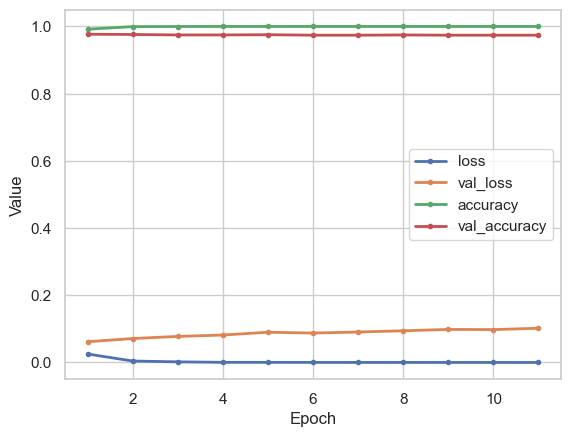

In [25]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [26]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step

 6/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [27]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [28]:
k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

In [ ]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [ ]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

In [ ]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [ ]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save('end')

In [ ]:
# END

In [ ]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################